In [1]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing
price_list = processing.import_binance_prices(assets=['DOT', 'ETH', 'BTC', 'DOGE'], start_date='Nov 1 2022', days=90)
# price_list += [price_list[0]] * 10
print(price_list[0:10])

[{'DOT': 6.62, 'ETH': 1572.69, 'BTC': 20490.74, 'DOGE': 0.12685}, {'DOT': 6.63, 'ETH': 1572.69, 'BTC': 20491.49, 'DOGE': 0.12684}, {'DOT': 6.62, 'ETH': 1573.54, 'BTC': 20493.67, 'DOGE': 0.12714}, {'DOT': 6.62, 'ETH': 1573.09, 'BTC': 20490.01, 'DOGE': 0.12679}, {'DOT': 6.62, 'ETH': 1571.2, 'BTC': 20475.95, 'DOGE': 0.1262}, {'DOT': 6.62, 'ETH': 1571.44, 'BTC': 20474.28, 'DOGE': 0.12611}, {'DOT': 6.62, 'ETH': 1570.52, 'BTC': 20466.76, 'DOGE': 0.12578}, {'DOT': 6.61, 'ETH': 1570.53, 'BTC': 20466.56, 'DOGE': 0.12568}, {'DOT': 6.62, 'ETH': 1570.46, 'BTC': 20466.56, 'DOGE': 0.12579}, {'DOT': 6.62, 'ETH': 1570.24, 'BTC': 20464.07, 'DOGE': 0.12587}]


In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

parameter_ranges = {
    'lrna_amp': (0.05, 2, 10),
    'lrna_decay': (0.000005, 0.00005, 10),
    'lrna_max': (0.01, 0.1, 5),
    'asset_amp': (0.1, 2, 10),
    'asset_decay': (0.000005, 0.0001, 10),
    'asset_max': (0.3, 0.5, 4),
    'oracle_length': (5, 500, 10)
}

def pass_along(min_value, max_value, steps, current):
    return min_value + (max_value - min_value) * current ** 2 / (steps - 1) ** 2

result_key = []
for a in range(parameter_ranges['lrna_amp'][2]):
    for b in range(parameter_ranges['lrna_decay'][2]):
        for c in range(parameter_ranges['lrna_max'][2]):
            for d in range(parameter_ranges['asset_amp'][2]):
                for e in range(parameter_ranges['asset_decay'][2]):
                    for f in range(parameter_ranges['asset_max'][2]):
                        for g in range(parameter_ranges['oracle_length'][2]):
                            result_key.append ((
                                pass_along(*parameter_ranges['lrna_amp'], a),
                                pass_along(*parameter_ranges['lrna_decay'], b),
                                pass_along(*parameter_ranges['lrna_max'], c),
                                pass_along(*parameter_ranges['asset_amp'], d),
                                pass_along(*parameter_ranges['asset_decay'], e),
                                pass_along(*parameter_ranges['asset_max'], f),
                                # pass_along(*parameter_ranges['lrna_amp'], a) * 5,
                                # pass_along(*parameter_ranges['lrna_decay'], b) * 5,
                                # pass_along(*parameter_ranges['lrna_max'], c) * 5,
                                pass_along(*parameter_ranges['oracle_length'], g)
                            ))
random.shuffle(result_key)
print (f'trying {len(result_key)} total parameter combinations...')

trying 2000000 total parameter combinations...


In [3]:
assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.20},
    'DOGE': {'usd price': price_list[0]['DOGE'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
            lrna_fee=0,
            asset_fee=0,
        )
    },
    agents = {
        'Trader': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'ETH': 1000000000, 'BTC': 3000000000, 'DOGE': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000},
            trade_strategy=price_sensitive_trading(
                pool_id='omnipool', max_volume_usd=80, price_sensitivity=20
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all = False
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')

class FeeParams:
    def __init__(self, lrna_amp: float, lrna_decay: float, lrna_max: float, asset_amp: float, asset_decay: float, asset_max: float, oracle_length: float, holdings: float):
        self.lrna_amp = lrna_amp
        self.lrna_decay = lrna_decay
        self.lrna_max = lrna_max
        self.asset_amp = asset_amp
        self.asset_decay = asset_decay
        self.asset_max = asset_max
        self.oracle_length = oracle_length
        self.holdings = holdings
        
    def __repr__(self):
        return (
            f'lrna fee amplification: {self.lrna_amp}\n'
            f'lrna fee decay: {self.lrna_decay}\n'
            f'lrna fee max: {self.lrna_max}\n'
            f'asset fee amplification: {self.asset_amp}\n'
            f'asset fee decay: {self.asset_decay}\n'
            f'asset fee max: {self.asset_max}\n'
            f'oracle length: {self.oracle_length}\n'
            f'LP final holdings: {self.holdings}\n'
        )
    
    def csv(self):
        return ', '.join([
            str(self.lrna_amp), 
            str(self.lrna_decay), 
            str(self.lrna_max), 
            str(self.asset_amp), 
            str(self.asset_decay), 
            str(self.asset_max), 
            str(self.oracle_length),
            str(self.holdings)
        ])
    
# load existing results
test_results = []

path = './output/dynamic_fees_comparison_results.csv'
if os.path.exists(path):
    # pick up where we left off
    with open(path, 'r') as file:
        data = [FeeParams(*[float(num) for num in line.split(',')]) for line in file.readlines()]
        test_results = data

    print ('last result (from file) \n', test_results[-1])
    print ('next up:', FeeParams(*result_key[len(test_results)], 0))


for key in result_key[len(test_results):]:
    random.seed(42)
    test_state = initial_state.copy()
    test_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
        minimum=0.0005,
        amplification=key[0],
        raise_oracle_name='fee_raise',
        decay=key[1],
        fee_max=key[2],
    )
    test_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
        minimum=0.0025,
        amplification=key[3],
        raise_oracle_name='fee_raise',
        decay=key[4],
        fee_max=key[5],
    )
    test_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (key[6] + 1)
    events = run.run(test_state, time_steps=time_steps)
    # print(events[-1])
    LP_returns = cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['LP'], events[-1].external_market)
    test_results.append(FeeParams(*key, LP_returns))
    print(key)
    print(f'returns = {LP_returns}')
    
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 647587 time steps
Starting simulation...
Execution time: 43.543 seconds.
(0.1462962962962963, 3.222222222222222e-05, 0.060625000000000005, 0.6864197530864198, 5e-06, 0.3222222222222222, 304.44444444444446)
returns = 997831.8968471971
Starting simulation...
Execution time: 42.599 seconds.
(0.26666666666666666, 1.388888888888889e-05, 0.060625000000000005, 1.2493827160493827, 8.006172839506173e-05, 0.5, 225.0)
returns = 997686.3403517641
Starting simulation...
Execution time: 35.245 seconds.
(1.2296296296296296, 1e-05, 0.1, 0.19382716049382714, 1.555555555555556e-05, 0.3222222222222222, 5.0)
returns = 997976.8386597773
Starting simulation...
Execution time: 37.735 seconds.
(0.4351851851851852, 1.8888888888888893e-05, 0.01, 0.3111111111111111, 8.006172839506173e-05, 0.5, 102.77777777777777)
returns = 997686.521874282
Starting simulation...
Execution time: 34.826 seconds.
(0.6518518518518519, 1.388888888888889e-05, 0.060625000000000005, 0.47530864197530864, 6.17283950617284e-06

KeyboardInterrupt: 

In [4]:
test_results.sort(key=lambda x: x.holdings)
# ensure no duplicates
if len(set([
    (result.lrna_max, result.lrna_decay, result.lrna_amp, result.asset_amp, result.asset_max, result.asset_decay, result.oracle_length) 
    for result in test_results
])) != len(test_results):
    raise
with open('./output/dynamic_fees_comparison_results.csv', 'w') as file:
    file.write('\n'.join([feeParam.csv() for feeParam in test_results]))


In [5]:
print(len(test_results))
print(test_results[-1])
print(test_results[0])

518
lrna fee amplification: 0.9166666666666667
lrna fee decay: 5e-06
lrna fee max: 0.015625
asset fee amplification: 2.0
asset fee decay: 6.17283950617284e-06
asset fee max: 0.5
oracle length: 11.11111111111111
LP final holdings: 998610.8600197318

lrna fee amplification: 0.1462962962962963
lrna fee decay: 1e-05
lrna fee max: 0.0325
asset fee amplification: 1.6012345679012345
asset fee decay: 6.246913580246914e-05
asset fee max: 0.5
oracle length: 500.0
LP final holdings: 997686.3225876297



In [6]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].asset_fee=0.0025
basic_state.pools['omnipool'].lrna_fee=0.0005

events = run.run(basic_state, time_steps=time_steps)



Starting simulation...
Execution time: 36.678 seconds.


In [7]:
winning_state = initial_state.copy()
winning_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[-1].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].lrna_decay,
    fee_max=test_results[-1].lrna_max,
)
winning_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[-1].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].asset_decay,
    fee_max=test_results[-1].asset_max,
)
winning_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
events2 = run.run(winning_state, time_steps=time_steps)

Starting simulation...
Execution time: 51.633 seconds.


In [8]:
losing_state = initial_state.copy()
losing_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[0].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].lrna_decay,
    fee_max=test_results[0].lrna_max,
)
losing_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[0].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].asset_decay,
    fee_max=test_results[0].asset_max,
)
losing_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[0].oracle_length + 1)
events3 = run.run(losing_state, time_steps=time_steps)

Starting simulation...
Execution time: 234.473 seconds.


In [9]:
LP_holdings1 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events]
LP_holdings2 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events2]
LP_holdings3 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events3]

Text(0.5, 1.0, 'basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green)')

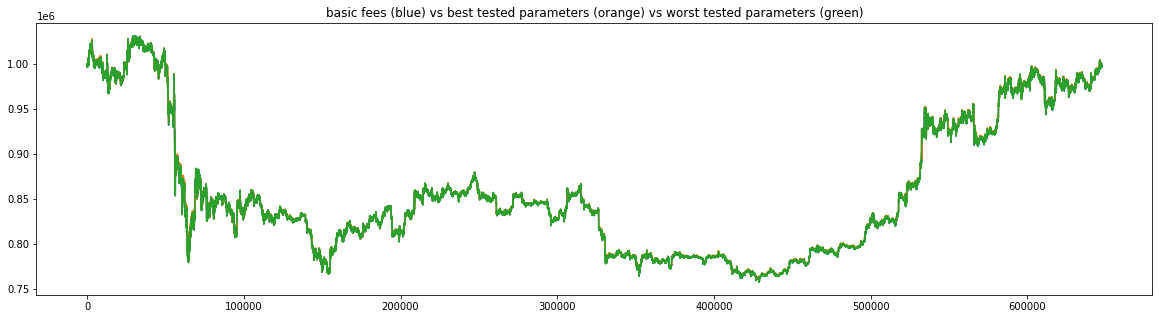

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(LP_holdings1)), LP_holdings1)
plt.plot(range(len(LP_holdings2)), LP_holdings2)
plt.plot(range(len(LP_holdings3)), LP_holdings3)
plt.title('basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green)')

In [11]:
print(LP_holdings1[-1])
print(LP_holdings2[-1])
print(LP_holdings3[-1])

In [12]:
print(test_results[-1])

lrna fee amplification: 0.9166666666666667
lrna fee decay: 5e-06
lrna fee max: 0.015625
asset fee amplification: 2.0
asset fee decay: 6.17283950617284e-06
asset fee max: 0.5
oracle length: 11.11111111111111
LP final holdings: 998610.8600197318



In [ ]:
random.seed(42)
basic_state2 = initial_state.copy()
basic_state2.pools['omnipool'].asset_fee=0.0025
basic_state2.pools['omnipool'].lrna_fee=0.0005

events4=run.run(basic_state2, time_steps=time_steps)
LP_holdings4 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events4[::20]]


In [ ]:
random.seed(42)
basic_state3 = initial_state.copy()
basic_state3.pools['omnipool'].asset_fee=0.0025
basic_state3.pools['omnipool'].lrna_fee=0.0005

events5=run.run(basic_state3, time_steps=time_steps)
LP_holdings5 = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events5[::20]]


In [ ]:

print(LP_holdings1[-1])
print(LP_holdings2[-1])
print(LP_holdings3[-1])
print(LP_holdings4[-1])
print(LP_holdings5[-1])


In [ ]:
# print(events[0], events[1000])

In [ ]:
print(winning_state, losing_state)

In [ ]:
pu.plot(events, asset='DOGE')

In [ ]:
ax = pu.plot(events, pool='omnipool', oracle='fee_raise', prop='volume_in', key='DOT')
pu.plot(events2, pool='omnipool', oracle='fee_raise', prop='volume_in', key='DOT', subplot=ax)

In [ ]:
print(test_results[0])
print(test_results[-1])

In [ ]:
volume_out_usd = [event.pools['omnipool'].oracles['fee_raise'].price['USD'] for event in events3]
plt.plot(range(len(volume_out_usd)), volume_out_usd)

In [ ]:
reverse_price_list = list(reversed(processing.import_binance_prices(assets=['DOT', 'ETH', 'BTC', 'DOGE'], start_date='Nov 1 2022', days=30)))
reverse_basic_state = initial_state.copy()
reverse_basic_state._evolve_function=historical_prices(reverse_price_list)
reverse_basic_events = run.run(reverse_basic_state, time_steps = time_steps)

reverse_state = reverse_basic_state.copy()
reverse_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[-1].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].lrna_decay,
    fee_max=test_results[-1].lrna_max,
)
reverse_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[-1].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[-1].asset_decay,
    fee_max=test_results[-1].asset_max,
)
reverse_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
reverse_events = run.run(reverse_state, time_steps = time_steps)

worst_reverse_state = reverse_state.copy()
worst_reverse_state.pools['omnipool'].lrna_fee = dynamicadd_lrna_fee(
    minimum=0.0005,
    amplification=test_results[0].lrna_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].lrna_decay,
    fee_max=test_results[0].lrna_max,
)
worst_reverse_state.pools['omnipool'].asset_fee = dynamicadd_asset_fee(
    minimum=0.0025,
    amplification=test_results[0].asset_amp,
    raise_oracle_name='fee_raise',
    decay=test_results[0].asset_decay,
    fee_max=test_results[0].asset_max,
)
worst_reverse_state.pools['omnipool'].oracles['fee_raise'].decay_factor = 2 / (test_results[-1].oracle_length + 1)
worst_reverse_events = run.run(worst_reverse_state, time_steps = time_steps)


In [ ]:
reverse_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in reverse_events[::20]]
worst_reverse_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in worst_reverse_events[::20]]
reverse_basic_LP_holdings = [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in reverse_basic_events[::20]]
plt.figure(figsize=(20, 5))
plt.plot(range(len(reverse_LP_holdings)), reverse_basic_LP_holdings)
plt.plot(range(len(reverse_LP_holdings)), reverse_LP_holdings)
plt.plot(range(len(reverse_LP_holdings)), worst_reverse_LP_holdings)
plt.title('basic fees (blue) vs best tested parameters (orange) vs worst tested parameters (green) with price movement reversed')

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(price_list)), [price_list[i]['ETH'] for i in range(len(price_list))])
plt.plot(range(len(price_list)), [reverse_price_list[i]['ETH'] for i in range(len(price_list))])
plt.title('two different, opposite price runs')

In [ ]:
pu.plot(reverse_events, asset='ETH')

In [ ]:
pu.plot(reverse_events[::100], agent='Trader', prop='holdings', key='ETH')

In [ ]:
oracle = [event.pools['omnipool'].oracles['fee_raise'].volume_in['ETH'] for event in reverse_events][:100]
plt.plot(range(len(oracle)), oracle)

In [ ]:
pu.plot(reverse_events[::20], pool='omnipool', prop='last_fee')
pu.plot(reverse_events[::20], pool='omnipool', prop='last_lrna_fee')

pu.plot(events2[::20], pool='omnipool', prop='last_fee')
pu.plot(events2[::20], pool='omnipool', prop='last_lrna_fee')


In [ ]:
pu.plot(events[::20], pool='omnipool', oracle='fee_raise', prop='liquidity', key='HDX')